In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
def load_labels_from_txt(labels_folder):
    labels = []
    image_filenames = []
    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            image_filename = label_file.replace('.txt', '.jpeg')
            with open(os.path.join(labels_folder, label_file), 'r') as file:
                lines = file.readlines()
                if lines:
                    for line in lines:
                        try:
                            label = int(line.split()[0])
                            labels.append(label)
                            image_filenames.append(image_filename)
                        except ValueError:
                            print(f"Error parsing line: {line}")
    return image_filenames, np.array(labels)

In [4]:
import cv2

def load_images_from_filenames(image_filenames, images_folder, img_height, img_width):
    images = []
    for filename in image_filenames:
        img_path = os.path.join(images_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue
        img = cv2.resize(img, (img_height, img_width))
        img = img / 255.0 #Normalizing
        images.append(img)
    return np.array(images)

In [5]:
labels_folder = r'/content/gdrive/MyDrive/Riped and Unriped Tomato Dataset/labels'
images_folder = r'/content/gdrive/MyDrive/Riped and Unriped Tomato Dataset/Images'
img_height, img_width = 60,60

# Load data
image_filenames, labels = load_labels_from_txt(labels_folder)
images = load_images_from_filenames(image_filenames, images_folder, img_height, img_width)

# Check class distribution
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:")
print(class_distribution)

if len(class_distribution) < 2:
    raise ValueError("Dataset must contain at least two classes.")

Class distribution:
{0: 440, 1: 429}


In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
y_train = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(images, y_train, test_size=0.3, random_state=42)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import GlobalAveragePooling2D


# Build the CNN model
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),  # Reduced size
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,802 (1.36 MB)

 Trainable params: 356,802 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=32
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.8689 - loss: 0.3411 - val_accuracy: 0.8279 - val_loss: 0.3731
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.9082 - loss: 0.2569 - val_accuracy: 0.8361 - val_loss: 0.3628
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.8908 - loss: 0.2994 - val_accuracy: 0.8361 - val_loss: 0.3775
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.8503 - loss: 0.3703 - val_accuracy: 0.8361 - val_loss: 0.3717
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.8792 - loss: 0.2991 - val_accuracy: 0.8279 - val_loss: 0.3380
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.8666 - loss: 0.3003 - val_accuracy: 0.7869 - val_loss: 0.6429
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.8401 - loss: 0.4156 - val_accuracy: 0.7787 - val_loss: 0.4421
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.8573 - loss: 0.3239 - val_accuracy: 0.

In [55]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=['Unripe', 'Ripe']))

# Print accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Classification Report:
              precision    recall  f1-score   support

      Unripe       0.88      0.83      0.85       136
        Ripe       0.83      0.87      0.85       125

    accuracy                           0.85       261
   macro avg       0.85      0.85      0.85       261
weighted avg       0.85      0.85      0.85       261

Accuracy: 0.8506


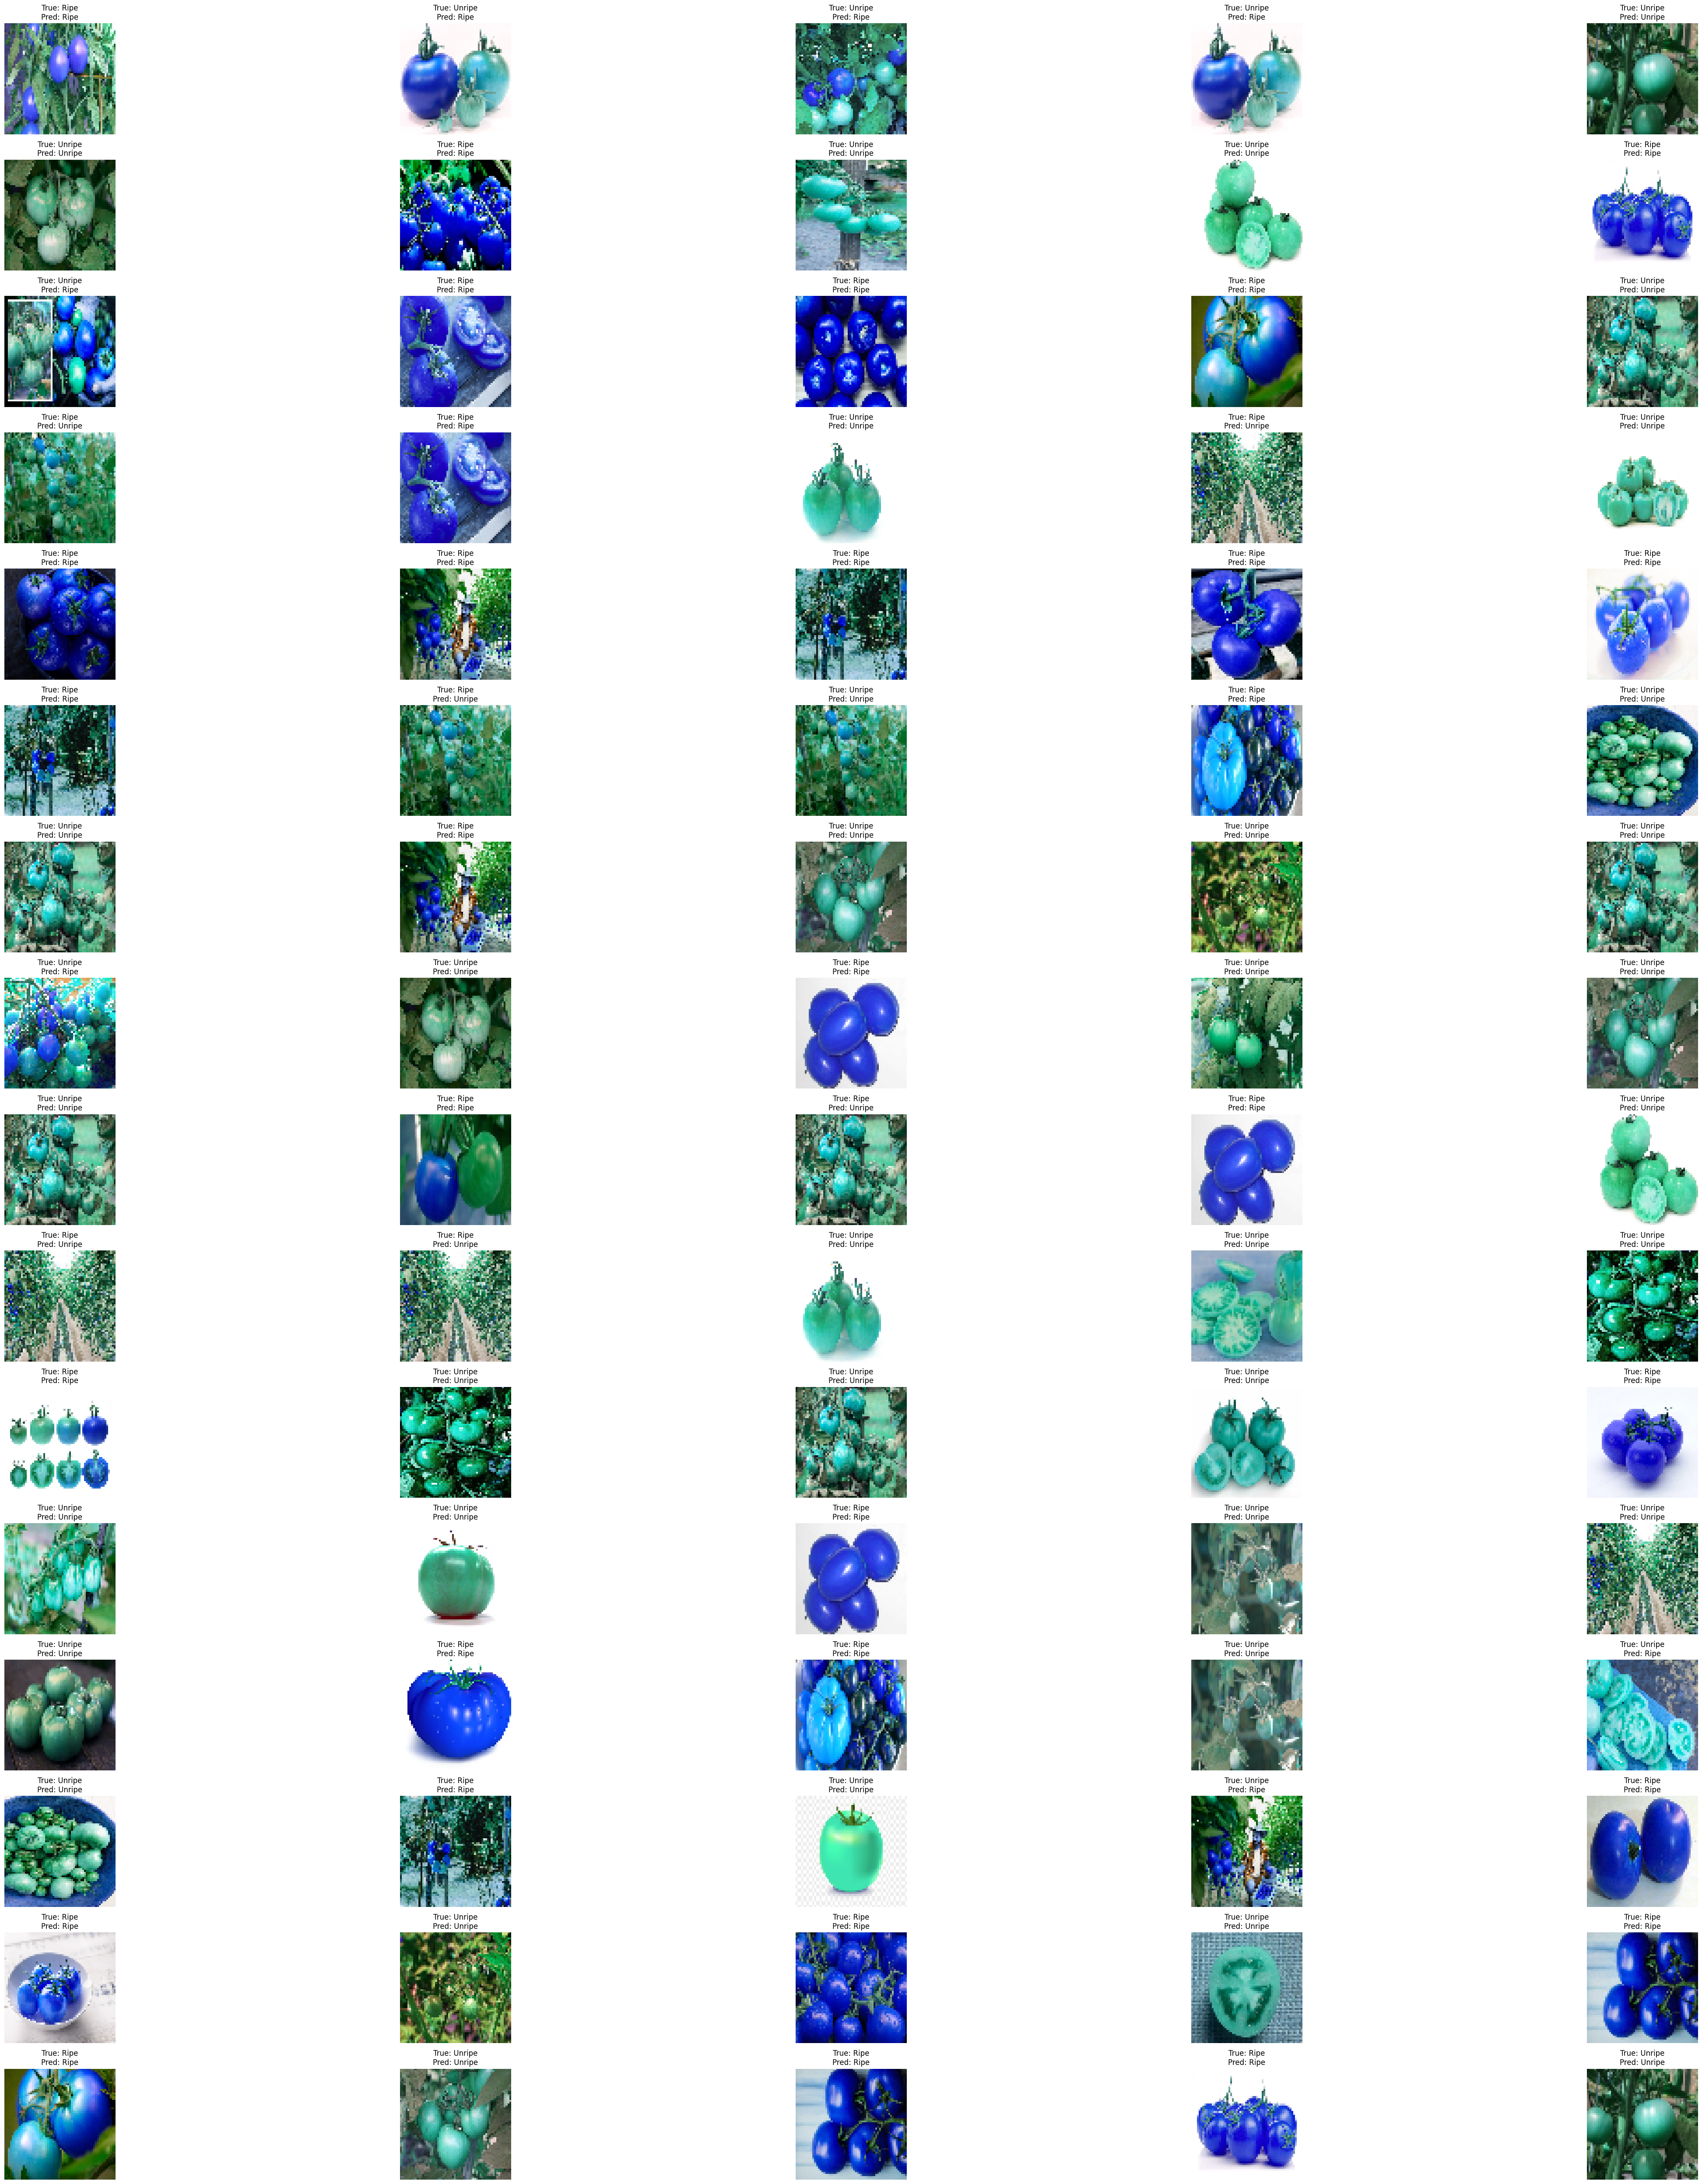

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_predictions_grid(X_test, y_test, y_pred_classes, class_names, num_samples=80, grid_size=(16, 5)):
    plt.figure(figsize=(50,50))

    num_samples = min(num_samples, grid_size[0] * grid_size[1])

    for i in range(num_samples):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(X_test[i])
        plt.title(f"True: {class_names[y_test[i]]}\nPred: {class_names[y_pred_classes[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_predictions_grid(X_test, y_test_classes, y_pred_classes, class_names=['Unripe', 'Ripe'])


#Adding a upload widget



In [57]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import io


In [58]:
# Define the upload widget
upload_widget = widgets.FileUpload(accept='image/jpeg', multiple=False)

# Function to preprocess the uploaded image and make a prediction
def predict_image(change):

    uploaded_file = list(change['new'].values())[0]
    image_data = uploaded_file['content']

    # Convert binary data to a PIL Image
    image = Image.open(io.BytesIO(image_data))

    # Resize and preprocess the image
    image = image.resize((60, 60))  
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0) 
    image_array = image_array / 255.0  # Normalize

    # Make a prediction
    prediction = model.predict(image_array)
    class_index = np.argmax(prediction, axis=1)[0]

    # Print the result
    class_names = ['Unripe', 'Ripe']  
    result = class_names[class_index]

    print(f'Prediction: {result}')


upload_widget.observe(predict_image, names='value')

# Display the upload widget
display(upload_widget)


FileUpload(value={}, accept='image/jpeg', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction: Ripe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction: Unripe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: Ripe
